In [1]:
%%capture capt
!pip install matplotlib torchsummary scikit-learn pandas
!pip install -U imbalanced-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchsummary import summary

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
from gilbert2d import gilbert2d

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model running on {device}.")

Model running on cuda.


## Data Loading

In [4]:
CLASSES = ["asymetric", "banded", "locked", "butterfly", "no_pattern"]

In [5]:
# Mapping int to categories
int_to_cat = {
    0: "asymetric",
    1: "banded",
    2: "locked",
    3: "butterfly",
    4: "no_pattern",
}

In [6]:
X_train = np.load("./data/X_train.npy")
y_train_df = pd.read_csv("./data/y_train.csv")

In [7]:
X_test = np.load("./data/X_test.npy")
y_test_df = pd.read_csv("./data/y_test.csv")

## SMOTE

In [8]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE

In [9]:
sm = SMOTE(k_neighbors=10)
#sm = KMeansSMOTE(k_neighbors=5)

In [10]:
X_train = X_train.reshape(len(X_train), -1)
X_train, y_train = sm.fit_resample(X_train, y_train_df.cat_num.values)
X_train = X_train.reshape(-1, 90, 180)

## Flatten with Peano curve

In [11]:
def flatten_peano(X):
    peano_indices = np.array(list(gilbert2d(X[0].shape[0], X[0].shape[1])))
    flat_indices = X[0].shape[1] * peano_indices[:, 0] + peano_indices[:, 1]
    return X.reshape(-1, X[0].shape[0]*X[0].shape[1])[:, flat_indices]

In [12]:
def max_pool(img, factor=3):
    """ Perform max pooling with a (factor x factor) kernel"""
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

vectorized_max_pool = np.vectorize(max_pool, signature='(m,n)->(k,l)')

In [13]:
def black_and_white(X):
    #return np.where(X > 0.5, 1, 0)
    return X

In [14]:
flattened_img_train = flatten_peano(vectorized_max_pool(black_and_white(X_train)))
flattened_img_test = flatten_peano(vectorized_max_pool(black_and_white(X_test)))

In [15]:
# Convert to PyTorch tensors
X_train = torch.tensor(np.array(flattened_img_train), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(np.array(flattened_img_test), dtype=torch.float32)
y_test = torch.tensor(y_test_df['cat_num'].values, dtype=torch.long)

In [16]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [17]:
print(f"X_train shape -> {X_train.shape}, y_train shape -> {y_train.shape}")
print(f"X_test shape -> {X_test.shape}, y_test shape -> {y_test.shape}")

X_train shape -> torch.Size([1660, 1800]), y_train shape -> torch.Size([1660])
X_test shape -> torch.Size([68, 1800]), y_test shape -> torch.Size([68])


## Display

In [18]:
def plot(x, title, ax):
    shape0 = int(np.sqrt(len(x)/2))
    ax.imshow(x.reshape(shape0, 2*shape0), cmap='gray')
    ax.set_title(title)

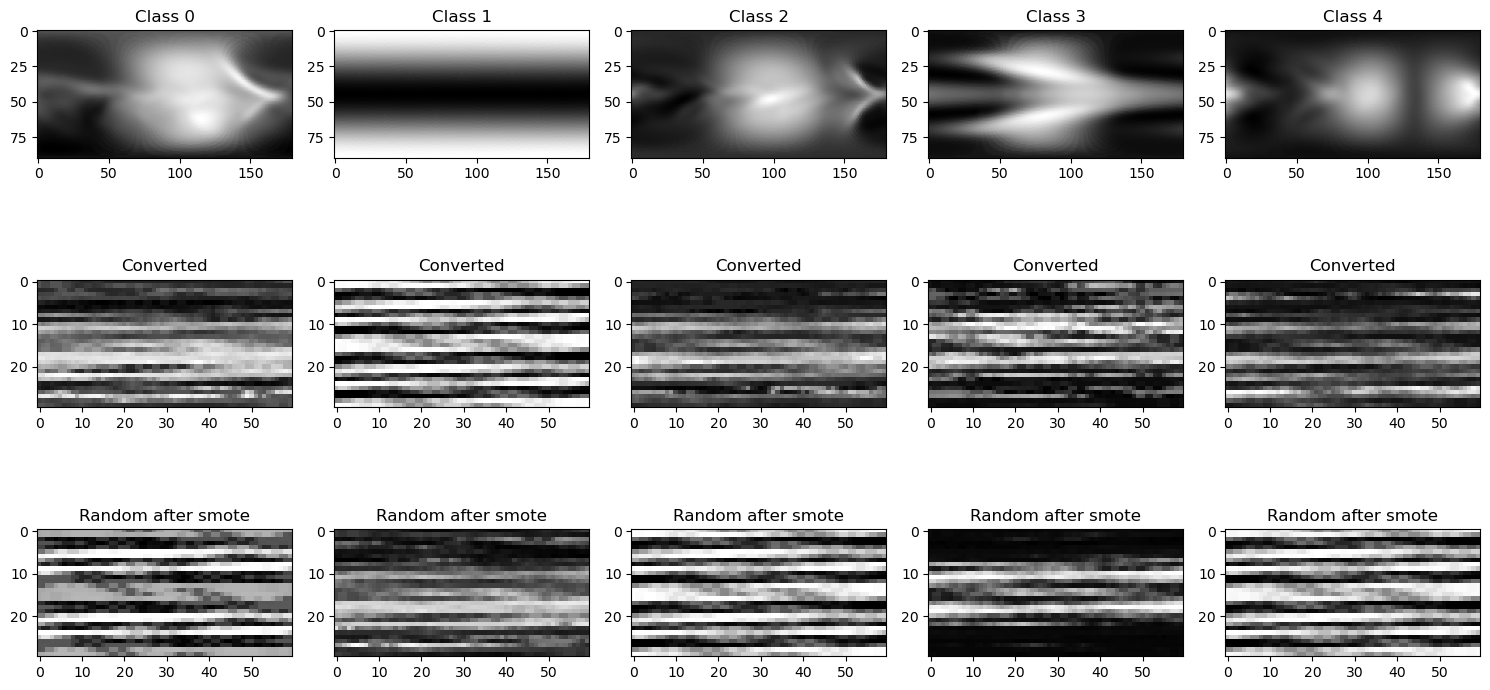

In [19]:
fig, axs = plt.subplots(3, 5, figsize=(15, 8))

for class_ in range(5):
    X_class_ = np.load("./data/X_train.npy")[pd.read_csv("./data/y_train.csv").cat_num.values == class_]
    x = X_class_[np.random.choice(range(len(X_class_)))].flatten()
    ax = axs[0][class_]
    plot(x, f'Class {class_}', ax)

    plot(flatten_peano(np.array([max_pool(x.reshape(90, 180))]))[0], 'Converted', axs[1][class_])

    plot_x_class = X_train.cpu().numpy()[np.random.choice(range(len(X_train)), size=1)]
    plot(plot_x_class[0], 'Random after smote', axs[2][class_])
plt.tight_layout()

# Train model

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
est = RandomForestClassifier(
    n_estimators=5000, max_depth=20, min_samples_split=2, verbose=10, n_jobs=-1
)

In [ ]:
est.fit(X_train.cpu(), y_train.cpu())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s


building tree 32 of 5000building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000

building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building tree 41 of 5000
building tree 42 of 5000
building tree 43 of 5000
building tree 44 of 5000
building tree 45 of 5000
building tree 46 of 5000
building tree 47 of 5000
building tree 48 of 5000
building tree 49 of 5000
building tree 50 of 5000
building tree 51 of 5000
building tree 52 of 5000
building tree 53 of 5000
building tree 54 of 5000
building tree 55 of 5000
building tree 56 of 5000
building tree 57 of 5000
building tree 58 of 5000
building tree 59 of 5000
building tree 60 of 5000


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.6s


building tree 61 of 5000
building tree 62 of 5000
building tree 63 of 5000
building tree 64 of 5000
building tree 65 of 5000
building tree 66 of 5000
building tree 67 of 5000
building tree 68 of 5000
building tree 69 of 5000
building tree 70 of 5000
building tree 71 of 5000
building tree 72 of 5000
building tree 73 of 5000
building tree 74 of 5000
building tree 75 of 5000
building tree 76 of 5000
building tree 77 of 5000


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.9s


building tree 78 of 5000
building tree 79 of 5000
building tree 80 of 5000
building tree 81 of 5000
building tree 82 of 5000
building tree 83 of 5000
building tree 84 of 5000
building tree 85 of 5000
building tree 86 of 5000
building tree 87 of 5000


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.4s


building tree 88 of 5000
building tree 89 of 5000
building tree 90 of 5000
building tree 91 of 5000
building tree 92 of 5000
building tree 93 of 5000
building tree 94 of 5000
building tree 95 of 5000
building tree 96 of 5000
building tree 97 of 5000
building tree 98 of 5000
building tree 99 of 5000
building tree 100 of 5000
building tree 101 of 5000
building tree 102 of 5000
building tree 103 of 5000
building tree 104 of 5000
building tree 105 of 5000
building tree 106 of 5000
building tree 107 of 5000
building tree 108 of 5000
building tree 109 of 5000
building tree 110 of 5000
building tree 111 of 5000
building tree 112 of 5000
building tree 113 of 5000
building tree 114 of 5000
building tree 115 of 5000


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    1.7s


building tree 116 of 5000
building tree 117 of 5000
building tree 118 of 5000
building tree 119 of 5000
building tree 120 of 5000
building tree 121 of 5000
building tree 122 of 5000
building tree 123 of 5000
building tree 124 of 5000
building tree 125 of 5000
building tree 126 of 5000
building tree 127 of 5000
building tree 128 of 5000
building tree 129 of 5000
building tree 130 of 5000
building tree 131 of 5000
building tree 132 of 5000
building tree 133 of 5000
building tree 134 of 5000
building tree 135 of 5000
building tree 136 of 5000
building tree 137 of 5000
building tree 138 of 5000
building tree 139 of 5000
building tree 140 of 5000


[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.0s


building tree 141 of 5000
building tree 142 of 5000
building tree 143 of 5000
building tree 144 of 5000
building tree 145 of 5000
building tree 146 of 5000
building tree 147 of 5000
building tree 148 of 5000
building tree 149 of 5000
building tree 150 of 5000
building tree 151 of 5000
building tree 152 of 5000


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    2.4s


building tree 153 of 5000
building tree 154 of 5000
building tree 155 of 5000
building tree 156 of 5000
building tree 157 of 5000
building tree 158 of 5000
building tree 159 of 5000
building tree 160 of 5000
building tree 161 of 5000
building tree 162 of 5000
building tree 163 of 5000
building tree 164 of 5000
building tree 165 of 5000
building tree 166 of 5000
building tree 167 of 5000
building tree 168 of 5000
building tree 169 of 5000
building tree 170 of 5000
building tree 171 of 5000
building tree 172 of 5000
building tree 173 of 5000
building tree 174 of 5000
building tree 175 of 5000
building tree 176 of 5000
building tree 177 of 5000
building tree 178 of 5000
building tree 179 of 5000
building tree 180 of 5000
building tree 181 of 5000
building tree 182 of 5000


[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    2.7s


building tree 183 of 5000
building tree 184 of 5000
building tree 185 of 5000
building tree 186 of 5000
building tree 187 of 5000
building tree 188 of 5000
building tree 189 of 5000
building tree 190 of 5000
building tree 191 of 5000
building tree 192 of 5000
building tree 193 of 5000


[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    3.1s


building tree 194 of 5000
building tree 195 of 5000
building tree 196 of 5000
building tree 197 of 5000
building tree 198 of 5000
building tree 199 of 5000
building tree 200 of 5000
building tree 201 of 5000
building tree 202 of 5000
building tree 203 of 5000
building tree 204 of 5000
building tree 205 of 5000
building tree 206 of 5000
building tree 207 of 5000
building tree 208 of 5000
building tree 209 of 5000
building tree 210 of 5000
building tree 211 of 5000
building tree 212 of 5000
building tree 213 of 5000
building tree 214 of 5000
building tree 215 of 5000
building tree 216 of 5000
building tree 217 of 5000
building tree 218 of 5000
building tree 219 of 5000
building tree 220 of 5000
building tree 221 of 5000
building tree 222 of 5000


[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    3.5s


building tree 223 of 5000
building tree 224 of 5000
building tree 225 of 5000
building tree 226 of 5000
building tree 227 of 5000
building tree 228 of 5000
building tree 229 of 5000
building tree 230 of 5000
building tree 231 of 5000
building tree 232 of 5000
building tree 233 of 5000
building tree 234 of 5000
building tree 235 of 5000
building tree 236 of 5000
building tree 237 of 5000
building tree 238 of 5000


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    3.8s


building tree 239 of 5000
building tree 240 of 5000
building tree 241 of 5000
building tree 242 of 5000
building tree 243 of 5000
building tree 244 of 5000
building tree 245 of 5000
building tree 246 of 5000
building tree 247 of 5000
building tree 248 of 5000
building tree 249 of 5000
building tree 250 of 5000
building tree 251 of 5000
building tree 252 of 5000
building tree 253 of 5000
building tree 254 of 5000
building tree 255 of 5000
building tree 256 of 5000
building tree 257 of 5000
building tree 258 of 5000
building tree 259 of 5000
building tree 260 of 5000
building tree 261 of 5000
building tree 262 of 5000
building tree 263 of 5000
building tree 264 of 5000
building tree 265 of 5000


[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.2s


building tree 266 of 5000
building tree 267 of 5000
building tree 268 of 5000
building tree 269 of 5000
building tree 270 of 5000
building tree 271 of 5000
building tree 272 of 5000
building tree 273 of 5000
building tree 274 of 5000
building tree 275 of 5000
building tree 276 of 5000
building tree 277 of 5000
building tree 278 of 5000
building tree 279 of 5000
building tree 280 of 5000
building tree 281 of 5000
building tree 282 of 5000
building tree 283 of 5000
building tree 284 of 5000
building tree 285 of 5000
building tree 286 of 5000
building tree 287 of 5000
building tree 288 of 5000
building tree 289 of 5000
building tree 290 of 5000
building tree 291 of 5000
building tree 292 of 5000
building tree 293 of 5000


[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:    4.8s


building tree 294 of 5000building tree 295 of 5000

building tree 296 of 5000
building tree 297 of 5000
building tree 298 of 5000
building tree 299 of 5000
building tree 300 of 5000
building tree 301 of 5000
building tree 302 of 5000
building tree 303 of 5000
building tree 304 of 5000
building tree 305 of 5000
building tree 306 of 5000
building tree 307 of 5000
building tree 308 of 5000
building tree 309 of 5000
building tree 310 of 5000
building tree 311 of 5000
building tree 312 of 5000
building tree 313 of 5000
building tree 314 of 5000
building tree 315 of 5000
building tree 316 of 5000
building tree 317 of 5000
building tree 318 of 5000


[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    5.2s


building tree 319 of 5000
building tree 320 of 5000
building tree 321 of 5000
building tree 322 of 5000
building tree 323 of 5000
building tree 324 of 5000
building tree 325 of 5000
building tree 326 of 5000
building tree 327 of 5000
building tree 328 of 5000
building tree 329 of 5000
building tree 330 of 5000
building tree 331 of 5000
building tree 332 of 5000
building tree 333 of 5000
building tree 334 of 5000
building tree 335 of 5000
building tree 336 of 5000
building tree 337 of 5000
building tree 338 of 5000
building tree 339 of 5000
building tree 340 of 5000
building tree 341 of 5000
building tree 342 of 5000


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    5.6s


building tree 343 of 5000
building tree 344 of 5000
building tree 345 of 5000
building tree 346 of 5000
building tree 347 of 5000
building tree 348 of 5000
building tree 349 of 5000
building tree 350 of 5000
building tree 351 of 5000
building tree 352 of 5000
building tree 353 of 5000
building tree 354 of 5000
building tree 355 of 5000
building tree 356 of 5000
building tree 357 of 5000
building tree 358 of 5000
building tree 359 of 5000
building tree 360 of 5000
building tree 361 of 5000
building tree 362 of 5000
building tree 363 of 5000
building tree 364 of 5000
building tree 365 of 5000
building tree 366 of 5000
building tree 367 of 5000
building tree 368 of 5000
building tree 369 of 5000
building tree 370 of 5000


[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    6.1s


building tree 371 of 5000
building tree 372 of 5000
building tree 373 of 5000
building tree 374 of 5000
building tree 375 of 5000
building tree 376 of 5000
building tree 377 of 5000
building tree 378 of 5000
building tree 379 of 5000
building tree 380 of 5000
building tree 381 of 5000
building tree 382 of 5000
building tree 383 of 5000
building tree 384 of 5000
building tree 385 of 5000
building tree 386 of 5000
building tree 387 of 5000
building tree 388 of 5000
building tree 389 of 5000
building tree 390 of 5000
building tree 391 of 5000
building tree 392 of 5000
building tree 393 of 5000
building tree 394 of 5000
building tree 395 of 5000
building tree 396 of 5000
building tree 397 of 5000


[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:    6.6s


building tree 398 of 5000
building tree 399 of 5000
building tree 400 of 5000
building tree 401 of 5000
building tree 402 of 5000
building tree 403 of 5000
building tree 404 of 5000
building tree 405 of 5000
building tree 406 of 5000
building tree 407 of 5000
building tree 408 of 5000
building tree 409 of 5000
building tree 410 of 5000
building tree 411 of 5000
building tree 412 of 5000
building tree 413 of 5000
building tree 414 of 5000
building tree 415 of 5000
building tree 416 of 5000
building tree 417 of 5000
building tree 418 of 5000
building tree 419 of 5000
building tree 420 of 5000
building tree 421 of 5000
building tree 422 of 5000
building tree 423 of 5000
building tree 424 of 5000
building tree 425 of 5000
building tree 426 of 5000
building tree 427 of 5000


[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    7.2s


building tree 428 of 5000
building tree 429 of 5000
building tree 430 of 5000
building tree 431 of 5000
building tree 432 of 5000
building tree 433 of 5000
building tree 434 of 5000
building tree 435 of 5000
building tree 436 of 5000
building tree 437 of 5000
building tree 438 of 5000
building tree 439 of 5000
building tree 440 of 5000
building tree 441 of 5000
building tree 442 of 5000
building tree 443 of 5000
building tree 444 of 5000
building tree 445 of 5000
building tree 446 of 5000
building tree 447 of 5000
building tree 448 of 5000
building tree 449 of 5000
building tree 450 of 5000
building tree 451 of 5000
building tree 452 of 5000
building tree 453 of 5000
building tree 454 of 5000


[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:    7.8s


building tree 455 of 5000
building tree 456 of 5000
building tree 457 of 5000
building tree 458 of 5000
building tree 459 of 5000
building tree 460 of 5000
building tree 461 of 5000
building tree 462 of 5000
building tree 463 of 5000
building tree 465 of 5000
building tree 464 of 5000
building tree 466 of 5000
building tree 467 of 5000
building tree 468 of 5000
building tree 469 of 5000
building tree 470 of 5000
building tree 471 of 5000
building tree 472 of 5000
building tree 473 of 5000
building tree 474 of 5000
building tree 475 of 5000
building tree 476 of 5000
building tree 477 of 5000
building tree 478 of 5000
building tree 479 of 5000
building tree 480 of 5000
building tree 481 of 5000
building tree 482 of 5000
building tree 483 of 5000
building tree 484 of 5000


[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:    8.3s


building tree 485 of 5000
building tree 486 of 5000
building tree 487 of 5000
building tree 488 of 5000
building tree 489 of 5000
building tree 490 of 5000
building tree 491 of 5000
building tree 492 of 5000
building tree 493 of 5000
building tree 494 of 5000
building tree 495 of 5000
building tree 496 of 5000
building tree 497 of 5000
building tree 498 of 5000
building tree 499 of 5000
building tree 500 of 5000
building tree 501 of 5000
building tree 502 of 5000
building tree 503 of 5000
building tree 504 of 5000
building tree 505 of 5000
building tree 506 of 5000
building tree 507 of 5000
building tree 508 of 5000
building tree 509 of 5000
building tree 510 of 5000
building tree 511 of 5000
building tree 512 of 5000
building tree 513 of 5000
building tree 514 of 5000
building tree 515 of 5000
building tree 516 of 5000
building tree 517 of 5000
building tree 518 of 5000
building tree 519 of 5000


[Parallel(n_jobs=-1)]: Done 485 tasks      | elapsed:    8.8s


building tree 520 of 5000
building tree 521 of 5000
building tree 522 of 5000
building tree 523 of 5000
building tree 524 of 5000
building tree 525 of 5000
building tree 526 of 5000
building tree 527 of 5000
building tree 528 of 5000
building tree 529 of 5000
building tree 530 of 5000
building tree 531 of 5000
building tree 532 of 5000
building tree 533 of 5000building tree 534 of 5000
building tree 535 of 5000

building tree 536 of 5000
building tree 537 of 5000
building tree 538 of 5000
building tree 539 of 5000
building tree 540 of 5000
building tree 541 of 5000
building tree 542 of 5000
building tree 543 of 5000
building tree 544 of 5000
building tree 545 of 5000
building tree 546 of 5000
building tree 547 of 5000
building tree 548 of 5000building tree 549 of 5000
building tree 550 of 5000
building tree 551 of 5000

building tree 552 of 5000
building tree 553 of 5000
building tree 554 of 5000
building tree 555 of 5000
building tree 556 of 5000
building tree 557 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:    9.4s


building tree 560 of 5000
building tree 561 of 5000
building tree 562 of 5000
building tree 563 of 5000
building tree 564 of 5000
building tree 565 of 5000
building tree 566 of 5000
building tree 567 of 5000
building tree 568 of 5000
building tree 569 of 5000
building tree 570 of 5000
building tree 571 of 5000
building tree 572 of 5000
building tree 573 of 5000
building tree 574 of 5000
building tree 575 of 5000
building tree 576 of 5000
building tree 577 of 5000
building tree 578 of 5000
building tree 579 of 5000
building tree 580 of 5000
building tree 581 of 5000
building tree 582 of 5000
building tree 583 of 5000
building tree 584 of 5000
building tree 585 of 5000
building tree 586 of 5000
building tree 587 of 5000
building tree 588 of 5000
building tree 589 of 5000
building tree 590 of 5000
building tree 591 of 5000
building tree 592 of 5000
building tree 593 of 5000
building tree 594 of 5000
building tree 595 of 5000
building tree 596 of 5000


[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed:   10.0s


building tree 597 of 5000
building tree 598 of 5000
building tree 599 of 5000
building tree 600 of 5000
building tree 601 of 5000
building tree 602 of 5000
building tree 603 of 5000
building tree 604 of 5000
building tree 605 of 5000
building tree 606 of 5000
building tree 607 of 5000
building tree 608 of 5000
building tree 609 of 5000
building tree 610 of 5000
building tree 611 of 5000
building tree 612 of 5000
building tree 613 of 5000
building tree 614 of 5000
building tree 615 of 5000
building tree 616 of 5000building tree 617 of 5000
building tree 618 of 5000
building tree 619 of 5000

building tree 620 of 5000
building tree 621 of 5000
building tree 622 of 5000
building tree 623 of 5000
building tree 624 of 5000
building tree 625 of 5000
building tree 626 of 5000


[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   10.6s


building tree 627 of 5000
building tree 628 of 5000
building tree 629 of 5000
building tree 630 of 5000
building tree 631 of 5000
building tree 632 of 5000
building tree 633 of 5000
building tree 634 of 5000
building tree 635 of 5000
building tree 636 of 5000
building tree 637 of 5000
building tree 638 of 5000
building tree 639 of 5000
building tree 640 of 5000building tree 641 of 5000
building tree 642 of 5000

building tree 643 of 5000
building tree 644 of 5000
building tree 645 of 5000
building tree 646 of 5000
building tree 647 of 5000
building tree 648 of 5000
building tree 649 of 5000
building tree 650 of 5000
building tree 651 of 5000
building tree 652 of 5000
building tree 653 of 5000
building tree 654 of 5000building tree 655 of 5000
building tree 656 of 5000

building tree 657 of 5000
building tree 658 of 5000
building tree 659 of 5000
building tree 660 of 5000
building tree 661 of 5000
building tree 662 of 5000
building tree 663 of 5000
building tree 664 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 625 tasks      | elapsed:   11.3s


building tree 672 of 5000building tree 673 of 5000

building tree 674 of 5000
building tree 675 of 5000
building tree 676 of 5000
building tree 677 of 5000
building tree 678 of 5000
building tree 679 of 5000
building tree 680 of 5000
building tree 681 of 5000
building tree 682 of 5000
building tree 683 of 5000
building tree 684 of 5000
building tree 685 of 5000building tree 686 of 5000
building tree 687 of 5000
building tree 688 of 5000
building tree 689 of 5000

building tree 690 of 5000
building tree 691 of 5000
building tree 692 of 5000
building tree 693 of 5000
building tree 694 of 5000
building tree 695 of 5000
building tree 696 of 5000
building tree 697 of 5000
building tree 698 of 5000
building tree 699 of 5000


[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:   11.9s


building tree 700 of 5000building tree 701 of 5000
building tree 702 of 5000
building tree 703 of 5000
building tree 704 of 5000

building tree 705 of 5000
building tree 706 of 5000
building tree 707 of 5000
building tree 708 of 5000
building tree 709 of 5000
building tree 710 of 5000building tree 711 of 5000
building tree 712 of 5000

building tree 713 of 5000
building tree 714 of 5000
building tree 715 of 5000
building tree 716 of 5000
building tree 717 of 5000
building tree 718 of 5000
building tree 719 of 5000
building tree 720 of 5000
building tree 721 of 5000
building tree 722 of 5000
building tree 723 of 5000
building tree 724 of 5000
building tree 725 of 5000
building tree 726 of 5000
building tree 727 of 5000
building tree 728 of 5000building tree 729 of 5000

building tree 730 of 5000
building tree 731 of 5000
building tree 732 of 5000
building tree 733 of 5000
building tree 734 of 5000
building tree 735 of 5000
building tree 736 of 5000
building tree 737 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 701 tasks      | elapsed:   12.6s


building tree 741 of 5000
building tree 742 of 5000
building tree 743 of 5000
building tree 744 of 5000
building tree 745 of 5000
building tree 746 of 5000
building tree 747 of 5000
building tree 748 of 5000
building tree 749 of 5000
building tree 750 of 5000
building tree 751 of 5000
building tree 752 of 5000
building tree 753 of 5000
building tree 754 of 5000
building tree 755 of 5000
building tree 756 of 5000
building tree 757 of 5000
building tree 758 of 5000
building tree 759 of 5000
building tree 760 of 5000
building tree 762 of 5000
building tree 763 of 5000
building tree 764 of 5000
building tree 761 of 5000
building tree 765 of 5000
building tree 766 of 5000
building tree 767 of 5000
building tree 768 of 5000
building tree 769 of 5000
building tree 770 of 5000
building tree 771 of 5000
building tree 772 of 5000
building tree 773 of 5000
building tree 774 of 5000
building tree 775 of 5000
building tree 776 of 5000
building tree 777 of 5000
building tree 778 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:   13.3s


building tree 786 of 5000
building tree 787 of 5000
building tree 788 of 5000
building tree 789 of 5000
building tree 790 of 5000
building tree 791 of 5000
building tree 792 of 5000
building tree 793 of 5000
building tree 794 of 5000
building tree 795 of 5000
building tree 796 of 5000
building tree 797 of 5000
building tree 798 of 5000
building tree 799 of 5000
building tree 800 of 5000
building tree 801 of 5000
building tree 802 of 5000
building tree 803 of 5000
building tree 804 of 5000
building tree 805 of 5000
building tree 806 of 5000
building tree 807 of 5000
building tree 808 of 5000
building tree 809 of 5000
building tree 810 of 5000
building tree 811 of 5000
building tree 812 of 5000


[Parallel(n_jobs=-1)]: Done 781 tasks      | elapsed:   13.9s


building tree 813 of 5000
building tree 814 of 5000
building tree 815 of 5000
building tree 816 of 5000
building tree 817 of 5000
building tree 818 of 5000
building tree 819 of 5000
building tree 820 of 5000
building tree 821 of 5000
building tree 822 of 5000
building tree 823 of 5000
building tree 824 of 5000
building tree 825 of 5000
building tree 826 of 5000
building tree 827 of 5000
building tree 828 of 5000
building tree 829 of 5000
building tree 830 of 5000
building tree 831 of 5000
building tree 832 of 5000
building tree 833 of 5000
building tree 834 of 5000
building tree 835 of 5000
building tree 836 of 5000
building tree 837 of 5000
building tree 838 of 5000
building tree 839 of 5000
building tree 840 of 5000
building tree 841 of 5000
building tree 842 of 5000
building tree 843 of 5000
building tree 844 of 5000
building tree 845 of 5000
building tree 846 of 5000
building tree 847 of 5000
building tree 848 of 5000
building tree 849 of 5000
building tree 850 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 822 tasks      | elapsed:   14.6s


building tree 857 of 5000
building tree 858 of 5000
building tree 859 of 5000
building tree 860 of 5000
building tree 861 of 5000
building tree 862 of 5000
building tree 863 of 5000
building tree 864 of 5000
building tree 865 of 5000
building tree 866 of 5000
building tree 867 of 5000
building tree 868 of 5000
building tree 869 of 5000
building tree 870 of 5000
building tree 871 of 5000
building tree 872 of 5000
building tree 873 of 5000
building tree 874 of 5000
building tree 875 of 5000
building tree 876 of 5000
building tree 877 of 5000
building tree 878 of 5000
building tree 879 of 5000
building tree 880 of 5000
building tree 881 of 5000
building tree 882 of 5000
building tree 883 of 5000
building tree 884 of 5000
building tree 885 of 5000
building tree 886 of 5000
building tree 887 of 5000
building tree 888 of 5000
building tree 889 of 5000
building tree 890 of 5000
building tree 891 of 5000
building tree 892 of 5000
building tree 893 of 5000
building tree 894 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 865 tasks      | elapsed:   15.5s


building tree 901 of 5000building tree 902 of 5000

building tree 903 of 5000
building tree 904 of 5000
building tree 905 of 5000
building tree 906 of 5000
building tree 907 of 5000
building tree 908 of 5000
building tree 909 of 5000
building tree 910 of 5000
building tree 911 of 5000
building tree 912 of 5000
building tree 913 of 5000
building tree 914 of 5000
building tree 915 of 5000
building tree 916 of 5000
building tree 917 of 5000
building tree 918 of 5000
building tree 919 of 5000
building tree 920 of 5000
building tree 921 of 5000
building tree 922 of 5000
building tree 923 of 5000
building tree 924 of 5000
building tree 925 of 5000
building tree 926 of 5000
building tree 927 of 5000
building tree 928 of 5000
building tree 929 of 5000
building tree 930 of 5000
building tree 931 of 5000
building tree 932 of 5000
building tree 933 of 5000
building tree 934 of 5000
building tree 935 of 5000
building tree 936 of 5000
building tree 937 of 5000
building tree 938 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:   16.4s


building tree 947 of 5000
building tree 948 of 5000
building tree 949 of 5000
building tree 950 of 5000
building tree 951 of 5000
building tree 952 of 5000
building tree 953 of 5000
building tree 954 of 5000
building tree 955 of 5000
building tree 956 of 5000building tree 957 of 5000

building tree 958 of 5000
building tree 959 of 5000
building tree 960 of 5000
building tree 961 of 5000
building tree 962 of 5000
building tree 963 of 5000
building tree 964 of 5000
building tree 965 of 5000
building tree 966 of 5000
building tree 967 of 5000
building tree 968 of 5000
building tree 969 of 5000
building tree 970 of 5000
building tree 971 of 5000
building tree 972 of 5000
building tree 973 of 5000
building tree 974 of 5000
building tree 975 of 5000
building tree 976 of 5000
building tree 977 of 5000
building tree 978 of 5000
building tree 979 of 5000
building tree 980 of 5000
building tree 981 of 5000
building tree 982 of 5000
building tree 983 of 5000
building tree 984 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   17.2s


building tree 988 of 5000
building tree 989 of 5000
building tree 990 of 5000
building tree 991 of 5000
building tree 992 of 5000
building tree 993 of 5000
building tree 994 of 5000
building tree 995 of 5000
building tree 996 of 5000
building tree 997 of 5000
building tree 998 of 5000
building tree 999 of 5000
building tree 1000 of 5000
building tree 1001 of 5000
building tree 1002 of 5000
building tree 1003 of 5000
building tree 1004 of 5000
building tree 1005 of 5000
building tree 1006 of 5000
building tree 1007 of 5000
building tree 1008 of 5000
building tree 1009 of 5000
building tree 1010 of 5000
building tree 1011 of 5000
building tree 1012 of 5000
building tree 1013 of 5000building tree 1014 of 5000

building tree 1015 of 5000
building tree 1016 of 5000
building tree 1017 of 5000
building tree 1018 of 5000
building tree 1019 of 5000
building tree 1020 of 5000
building tree 1021 of 5000
building tree 1022 of 5000
building tree 1023 of 5000
building tree 1024 of 5000
building tree

[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:   18.0s


building tree 1034 of 5000
building tree 1035 of 5000
building tree 1036 of 5000
building tree 1037 of 5000
building tree 1038 of 5000
building tree 1039 of 5000
building tree 1040 of 5000
building tree 1041 of 5000
building tree 1042 of 5000
building tree 1043 of 5000
building tree 1044 of 5000
building tree 1045 of 5000
building tree 1046 of 5000
building tree 1047 of 5000
building tree 1048 of 5000
building tree 1049 of 5000
building tree 1050 of 5000
building tree 1051 of 5000
building tree 1052 of 5000
building tree 1053 of 5000
building tree 1054 of 5000
building tree 1055 of 5000
building tree 1056 of 5000
building tree 1057 of 5000
building tree 1058 of 5000
building tree 1059 of 5000
building tree 1060 of 5000
building tree 1061 of 5000
building tree 1062 of 5000
building tree 1063 of 5000
building tree 1064 of 5000
building tree 1065 of 5000
building tree 1066 of 5000
building tree 1067 of 5000building tree 1068 of 5000
building tree 1069 of 5000

building tree 1070 of 5000
b

[Parallel(n_jobs=-1)]: Done 1045 tasks      | elapsed:   18.9s


building tree 1084 of 5000
building tree 1085 of 5000
building tree 1086 of 5000
building tree 1087 of 5000
building tree 1088 of 5000
building tree 1089 of 5000
building tree 1090 of 5000
building tree 1091 of 5000
building tree 1092 of 5000
building tree 1093 of 5000
building tree 1094 of 5000
building tree 1095 of 5000
building tree 1096 of 5000
building tree 1097 of 5000
building tree 1098 of 5000
building tree 1099 of 5000
building tree 1100 of 5000
building tree 1101 of 5000
building tree 1102 of 5000
building tree 1103 of 5000
building tree 1104 of 5000
building tree 1105 of 5000
building tree 1106 of 5000
building tree 1107 of 5000
building tree 1108 of 5000
building tree 1109 of 5000
building tree 1110 of 5000
building tree 1111 of 5000building tree 1112 of 5000

building tree 1113 of 5000
building tree 1114 of 5000
building tree 1115 of 5000
building tree 1116 of 5000
building tree 1117 of 5000
building tree 1118 of 5000
building tree 1119 of 5000
building tree 1120 of 5000
b

[Parallel(n_jobs=-1)]: Done 1092 tasks      | elapsed:   19.7s


building tree 1127 of 5000
building tree 1128 of 5000
building tree 1129 of 5000
building tree 1130 of 5000
building tree 1131 of 5000
building tree 1132 of 5000
building tree 1133 of 5000
building tree 1134 of 5000
building tree 1135 of 5000
building tree 1136 of 5000
building tree 1137 of 5000
building tree 1138 of 5000
building tree 1139 of 5000
building tree 1140 of 5000
building tree 1141 of 5000
building tree 1142 of 5000
building tree 1143 of 5000
building tree 1144 of 5000
building tree 1145 of 5000
building tree 1146 of 5000
building tree 1147 of 5000
building tree 1148 of 5000
building tree 1149 of 5000
building tree 1150 of 5000
building tree 1151 of 5000
building tree 1152 of 5000
building tree 1153 of 5000
building tree 1154 of 5000
building tree 1155 of 5000
building tree 1156 of 5000
building tree 1157 of 5000
building tree 1158 of 5000
building tree 1159 of 5000
building tree 1160 of 5000
building tree 1161 of 5000
building tree 1162 of 5000building tree 1163 of 5000

b

[Parallel(n_jobs=-1)]: Done 1141 tasks      | elapsed:   20.6s


building tree 1178 of 5000building tree 1179 of 5000
building tree 1180 of 5000
building tree 1181 of 5000

building tree 1182 of 5000
building tree 1183 of 5000
building tree 1184 of 5000
building tree 1185 of 5000
building tree 1186 of 5000
building tree 1187 of 5000
building tree 1188 of 5000
building tree 1189 of 5000
building tree 1190 of 5000
building tree 1191 of 5000
building tree 1192 of 5000
building tree 1193 of 5000
building tree 1194 of 5000
building tree 1195 of 5000
building tree 1196 of 5000building tree 1197 of 5000
building tree 1198 of 5000
building tree 1199 of 5000
building tree 1200 of 5000

building tree 1201 of 5000
building tree 1202 of 5000
building tree 1203 of 5000
building tree 1204 of 5000
building tree 1205 of 5000
building tree 1206 of 5000
building tree 1207 of 5000
building tree 1208 of 5000
building tree 1209 of 5000
building tree 1210 of 5000
building tree 1211 of 5000
building tree 1212 of 5000
building tree 1213 of 5000
building tree 1214 of 5000
b

[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed:   21.4s


building tree 1223 of 5000
building tree 1224 of 5000
building tree 1225 of 5000
building tree 1226 of 5000
building tree 1227 of 5000
building tree 1228 of 5000
building tree 1229 of 5000
building tree 1230 of 5000
building tree 1231 of 5000
building tree 1232 of 5000
building tree 1233 of 5000
building tree 1234 of 5000
building tree 1235 of 5000
building tree 1236 of 5000
building tree 1237 of 5000
building tree 1238 of 5000
building tree 1239 of 5000
building tree 1240 of 5000
building tree 1241 of 5000
building tree 1242 of 5000
building tree 1243 of 5000
building tree 1244 of 5000
building tree 1245 of 5000
building tree 1246 of 5000
building tree 1247 of 5000
building tree 1248 of 5000
building tree 1249 of 5000
building tree 1250 of 5000building tree 1251 of 5000
building tree 1252 of 5000

building tree 1253 of 5000
building tree 1254 of 5000
building tree 1255 of 5000
building tree 1256 of 5000
building tree 1257 of 5000
building tree 1258 of 5000
building tree 1259 of 5000
b

[Parallel(n_jobs=-1)]: Done 1241 tasks      | elapsed:   22.3s


building tree 1276 of 5000building tree 1277 of 5000

building tree 1278 of 5000
building tree 1279 of 5000
building tree 1280 of 5000
building tree 1281 of 5000
building tree 1282 of 5000
building tree 1283 of 5000
building tree 1284 of 5000
building tree 1285 of 5000
building tree 1286 of 5000
building tree 1287 of 5000
building tree 1288 of 5000
building tree 1289 of 5000
building tree 1290 of 5000
building tree 1291 of 5000
building tree 1292 of 5000building tree 1293 of 5000

building tree 1294 of 5000
building tree 1295 of 5000
building tree 1296 of 5000
building tree 1297 of 5000
building tree 1298 of 5000
building tree 1299 of 5000
building tree 1300 of 5000
building tree 1301 of 5000
building tree 1302 of 5000
building tree 1303 of 5000
building tree 1304 of 5000
building tree 1305 of 5000
building tree 1306 of 5000
building tree 1307 of 5000
building tree 1308 of 5000
building tree 1309 of 5000
building tree 1310 of 5000
building tree 1311 of 5000
building tree 1312 of 5000
b

[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:   23.3s


building tree 1332 of 5000building tree 1333 of 5000

building tree 1334 of 5000
building tree 1335 of 5000
building tree 1336 of 5000
building tree 1337 of 5000
building tree 1338 of 5000
building tree 1339 of 5000
building tree 1340 of 5000
building tree 1341 of 5000
building tree 1342 of 5000
building tree 1343 of 5000
building tree 1344 of 5000
building tree 1345 of 5000
building tree 1346 of 5000
building tree 1347 of 5000
building tree 1348 of 5000
building tree 1349 of 5000
building tree 1350 of 5000
building tree 1351 of 5000
building tree 1352 of 5000
building tree 1353 of 5000
building tree 1354 of 5000
building tree 1355 of 5000
building tree 1356 of 5000
building tree 1357 of 5000
building tree 1358 of 5000
building tree 1359 of 5000
building tree 1360 of 5000
building tree 1361 of 5000
building tree 1362 of 5000
building tree 1363 of 5000
building tree 1364 of 5000
building tree 1365 of 5000
building tree 1366 of 5000
building tree 1367 of 5000
building tree 1368 of 5000
b

[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:   24.2s


building tree 1377 of 5000
building tree 1378 of 5000
building tree 1379 of 5000
building tree 1380 of 5000
building tree 1381 of 5000
building tree 1382 of 5000
building tree 1383 of 5000
building tree 1384 of 5000
building tree 1385 of 5000
building tree 1386 of 5000
building tree 1387 of 5000
building tree 1388 of 5000
building tree 1389 of 5000
building tree 1390 of 5000
building tree 1391 of 5000
building tree 1392 of 5000
building tree 1393 of 5000
building tree 1394 of 5000
building tree 1395 of 5000
building tree 1396 of 5000
building tree 1397 of 5000
building tree 1398 of 5000
building tree 1399 of 5000
building tree 1400 of 5000
building tree 1401 of 5000
building tree 1402 of 5000
building tree 1403 of 5000
building tree 1404 of 5000
building tree 1405 of 5000
building tree 1406 of 5000
building tree 1407 of 5000
building tree 1408 of 5000
building tree 1409 of 5000
building tree 1410 of 5000
building tree 1411 of 5000
building tree 1412 of 5000building tree 1413 of 5000

b

[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   25.2s


building tree 1437 of 5000
building tree 1438 of 5000
building tree 1439 of 5000
building tree 1440 of 5000
building tree 1441 of 5000
building tree 1442 of 5000
building tree 1443 of 5000
building tree 1444 of 5000
building tree 1445 of 5000
building tree 1446 of 5000
building tree 1447 of 5000
building tree 1448 of 5000
building tree 1449 of 5000
building tree 1450 of 5000
building tree 1451 of 5000
building tree 1452 of 5000
building tree 1453 of 5000
building tree 1454 of 5000
building tree 1455 of 5000
building tree 1456 of 5000
building tree 1457 of 5000
building tree 1458 of 5000
building tree 1459 of 5000
building tree 1460 of 5000
building tree 1461 of 5000
building tree 1462 of 5000
building tree 1463 of 5000building tree 1464 of 5000

building tree 1465 of 5000
building tree 1466 of 5000
building tree 1467 of 5000
building tree 1468 of 5000
building tree 1469 of 5000
building tree 1470 of 5000
building tree 1471 of 5000
building tree 1472 of 5000
building tree 1473 of 5000
b

[Parallel(n_jobs=-1)]: Done 1453 tasks      | elapsed:   26.1s


building tree 1491 of 5000building tree 1492 of 5000

building tree 1493 of 5000
building tree 1494 of 5000
building tree 1495 of 5000
building tree 1496 of 5000
building tree 1497 of 5000
building tree 1498 of 5000
building tree 1499 of 5000
building tree 1500 of 5000
building tree 1501 of 5000
building tree 1502 of 5000
building tree 1503 of 5000
building tree 1504 of 5000
building tree 1505 of 5000
building tree 1506 of 5000
building tree 1507 of 5000
building tree 1508 of 5000
building tree 1509 of 5000
building tree 1510 of 5000
building tree 1511 of 5000
building tree 1512 of 5000
building tree 1513 of 5000
building tree 1514 of 5000
building tree 1515 of 5000
building tree 1516 of 5000
building tree 1517 of 5000
building tree 1518 of 5000
building tree 1519 of 5000
building tree 1520 of 5000building tree 1521 of 5000
building tree 1522 of 5000

building tree 1523 of 5000
building tree 1524 of 5000
building tree 1525 of 5000
building tree 1526 of 5000
building tree 1527 of 5000
b

[Parallel(n_jobs=-1)]: Done 1508 tasks      | elapsed:   27.2s


building tree 1548 of 5000building tree 1549 of 5000

building tree 1550 of 5000
building tree 1551 of 5000
building tree 1552 of 5000
building tree 1553 of 5000
building tree 1554 of 5000
building tree 1555 of 5000
building tree 1556 of 5000
building tree 1557 of 5000
building tree 1558 of 5000
building tree 1559 of 5000
building tree 1560 of 5000
building tree 1561 of 5000
building tree 1562 of 5000
building tree 1563 of 5000
building tree 1564 of 5000building tree 1565 of 5000

building tree 1566 of 5000
building tree 1567 of 5000
building tree 1568 of 5000
building tree 1569 of 5000
building tree 1570 of 5000
building tree 1571 of 5000
building tree 1572 of 5000
building tree 1573 of 5000
building tree 1574 of 5000
building tree 1575 of 5000
building tree 1576 of 5000
building tree 1577 of 5000building tree 1578 of 5000
building tree 1579 of 5000
building tree 1580 of 5000

building tree 1581 of 5000
building tree 1582 of 5000
building tree 1583 of 5000
building tree 1584 of 5000
b

[Parallel(n_jobs=-1)]: Done 1565 tasks      | elapsed:   28.1s


building tree 1609 of 5000building tree 1610 of 5000
building tree 1611 of 5000

building tree 1612 of 5000
building tree 1613 of 5000
building tree 1614 of 5000
building tree 1615 of 5000
building tree 1616 of 5000
building tree 1617 of 5000
building tree 1618 of 5000
building tree 1619 of 5000
building tree 1620 of 5000
building tree 1621 of 5000
building tree 1622 of 5000
building tree 1623 of 5000
building tree 1624 of 5000
building tree 1625 of 5000
building tree 1626 of 5000
building tree 1627 of 5000
building tree 1628 of 5000
building tree 1629 of 5000
building tree 1630 of 5000
building tree 1631 of 5000
building tree 1632 of 5000
building tree 1633 of 5000
building tree 1634 of 5000
building tree 1635 of 5000
building tree 1636 of 5000building tree 1637 of 5000

building tree 1638 of 5000
building tree 1639 of 5000
building tree 1640 of 5000
building tree 1641 of 5000
building tree 1642 of 5000
building tree 1643 of 5000
building tree 1644 of 5000
building tree 1645 of 5000
b

[Parallel(n_jobs=-1)]: Done 1622 tasks      | elapsed:   29.0s


building tree 1658 of 5000
building tree 1659 of 5000
building tree 1660 of 5000
building tree 1661 of 5000
building tree 1662 of 5000
building tree 1663 of 5000
building tree 1664 of 5000
building tree 1665 of 5000
building tree 1666 of 5000
building tree 1667 of 5000
building tree 1668 of 5000
building tree 1669 of 5000building tree 1670 of 5000
building tree 1671 of 5000
building tree 1672 of 5000
building tree 1673 of 5000
building tree 1674 of 5000
building tree 1675 of 5000
building tree 1676 of 5000

building tree 1677 of 5000
building tree 1678 of 5000
building tree 1679 of 5000
building tree 1680 of 5000
building tree 1681 of 5000
building tree 1682 of 5000
building tree 1683 of 5000
building tree 1684 of 5000
building tree 1685 of 5000
building tree 1686 of 5000
building tree 1687 of 5000
building tree 1688 of 5000
building tree 1689 of 5000
building tree 1690 of 5000
building tree 1691 of 5000
building tree 1692 of 5000
building tree 1693 of 5000
building tree 1694 of 5000
b

[Parallel(n_jobs=-1)]: Done 1681 tasks      | elapsed:   30.1s


building tree 1735 of 5000building tree 1736 of 5000
building tree 1737 of 5000
building tree 1738 of 5000
building tree 1739 of 5000

building tree 1740 of 5000
building tree 1741 of 5000
building tree 1742 of 5000
building tree 1743 of 5000
building tree 1744 of 5000
building tree 1745 of 5000
building tree 1746 of 5000
building tree 1747 of 5000
building tree 1748 of 5000
building tree 1749 of 5000
building tree 1750 of 5000
building tree 1751 of 5000
building tree 1752 of 5000
building tree 1753 of 5000
building tree 1754 of 5000
building tree 1755 of 5000
building tree 1756 of 5000
building tree 1757 of 5000
building tree 1758 of 5000
building tree 1759 of 5000
building tree 1760 of 5000
building tree 1761 of 5000
building tree 1762 of 5000
building tree 1763 of 5000
building tree 1764 of 5000
building tree 1765 of 5000
building tree 1766 of 5000
building tree 1767 of 5000
building tree 1768 of 5000
building tree 1769 of 5000
building tree 1770 of 5000
building tree 1771 of 5000
b

[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:   31.1s


building tree 1782 of 5000
building tree 1783 of 5000
building tree 1784 of 5000
building tree 1785 of 5000
building tree 1786 of 5000
building tree 1787 of 5000
building tree 1788 of 5000
building tree 1789 of 5000
building tree 1790 of 5000
building tree 1791 of 5000
building tree 1792 of 5000
building tree 1793 of 5000
building tree 1794 of 5000
building tree 1795 of 5000
building tree 1796 of 5000building tree 1797 of 5000
building tree 1798 of 5000

building tree 1799 of 5000
building tree 1800 of 5000
building tree 1801 of 5000
building tree 1802 of 5000
building tree 1803 of 5000
building tree 1804 of 5000
building tree 1805 of 5000
building tree 1806 of 5000
building tree 1807 of 5000
building tree 1808 of 5000
building tree 1809 of 5000
building tree 1810 of 5000
building tree 1811 of 5000
building tree 1812 of 5000
building tree 1813 of 5000
building tree 1814 of 5000
building tree 1815 of 5000
building tree 1816 of 5000
building tree 1817 of 5000
building tree 1818 of 5000
b

[Parallel(n_jobs=-1)]: Done 1801 tasks      | elapsed:   32.3s


building tree 1834 of 5000building tree 1835 of 5000
building tree 1836 of 5000
building tree 1837 of 5000

building tree 1838 of 5000
building tree 1839 of 5000
building tree 1840 of 5000
building tree 1841 of 5000
building tree 1842 of 5000
building tree 1843 of 5000
building tree 1844 of 5000
building tree 1845 of 5000
building tree 1846 of 5000
building tree 1847 of 5000
building tree 1848 of 5000
building tree 1849 of 5000
building tree 1850 of 5000
building tree 1851 of 5000
building tree 1852 of 5000
building tree 1853 of 5000
building tree 1854 of 5000
building tree 1855 of 5000
building tree 1856 of 5000
building tree 1857 of 5000
building tree 1858 of 5000
building tree 1859 of 5000
building tree 1860 of 5000
building tree 1861 of 5000
building tree 1862 of 5000
building tree 1863 of 5000
building tree 1864 of 5000
building tree 1865 of 5000
building tree 1866 of 5000
building tree 1867 of 5000
building tree 1868 of 5000
building tree 1869 of 5000
building tree 1870 of 5000
b

[Parallel(n_jobs=-1)]: Done 1862 tasks      | elapsed:   33.4s


building tree 1901 of 5000
building tree 1902 of 5000
building tree 1903 of 5000
building tree 1904 of 5000
building tree 1905 of 5000
building tree 1906 of 5000
building tree 1907 of 5000
building tree 1908 of 5000
building tree 1909 of 5000
building tree 1910 of 5000
building tree 1911 of 5000
building tree 1912 of 5000
building tree 1913 of 5000
building tree 1914 of 5000
building tree 1915 of 5000
building tree 1916 of 5000
building tree 1917 of 5000
building tree 1918 of 5000
building tree 1919 of 5000
building tree 1920 of 5000
building tree 1921 of 5000
building tree 1922 of 5000
building tree 1923 of 5000
building tree 1924 of 5000
building tree 1925 of 5000
building tree 1926 of 5000
building tree 1927 of 5000
building tree 1928 of 5000
building tree 1929 of 5000
building tree 1930 of 5000
building tree 1931 of 5000
building tree 1932 of 5000
building tree 1933 of 5000
building tree 1934 of 5000
building tree 1935 of 5000
building tree 1936 of 5000
building tree 1938 of 5000
b

[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   34.3s


building tree 1970 of 5000
building tree 1971 of 5000
building tree 1972 of 5000
building tree 1973 of 5000
building tree 1974 of 5000
building tree 1975 of 5000
building tree 1976 of 5000
building tree 1977 of 5000
building tree 1978 of 5000
building tree 1979 of 5000
building tree 1980 of 5000
building tree 1981 of 5000
building tree 1982 of 5000
building tree 1983 of 5000
building tree 1984 of 5000
building tree 1985 of 5000
building tree 1986 of 5000
building tree 1987 of 5000
building tree 1988 of 5000
building tree 1989 of 5000
building tree 1990 of 5000
building tree 1991 of 5000
building tree 1992 of 5000
building tree 1993 of 5000
building tree 1994 of 5000
building tree 1995 of 5000
building tree 1996 of 5000
building tree 1997 of 5000
building tree 1998 of 5000
building tree 1999 of 5000
building tree 2000 of 5000
building tree 2001 of 5000
building tree 2002 of 5000
building tree 2003 of 5000
building tree 2004 of 5000
building tree 2005 of 5000
building tree 2006 of 5000
b

[Parallel(n_jobs=-1)]: Done 1988 tasks      | elapsed:   35.4s


building tree 2020 of 5000building tree 2021 of 5000

building tree 2022 of 5000
building tree 2023 of 5000
building tree 2024 of 5000
building tree 2025 of 5000
building tree 2026 of 5000
building tree 2027 of 5000
building tree 2028 of 5000
building tree 2029 of 5000
building tree 2030 of 5000
building tree 2031 of 5000
building tree 2032 of 5000
building tree 2033 of 5000
building tree 2034 of 5000
building tree 2035 of 5000
building tree 2036 of 5000
building tree 2037 of 5000
building tree 2038 of 5000
building tree 2039 of 5000
building tree 2040 of 5000
building tree 2041 of 5000
building tree 2042 of 5000
building tree 2043 of 5000
building tree 2044 of 5000
building tree 2045 of 5000
building tree 2046 of 5000
building tree 2047 of 5000
building tree 2048 of 5000building tree 2049 of 5000

building tree 2050 of 5000
building tree 2051 of 5000
building tree 2052 of 5000
building tree 2053 of 5000
building tree 2054 of 5000
building tree 2055 of 5000
building tree 2056 of 5000
b

[Parallel(n_jobs=-1)]: Done 2053 tasks      | elapsed:   36.6s


building tree 2088 of 5000
building tree 2089 of 5000
building tree 2090 of 5000
building tree 2091 of 5000
building tree 2092 of 5000
building tree 2093 of 5000
building tree 2094 of 5000
building tree 2095 of 5000
building tree 2096 of 5000
building tree 2097 of 5000
building tree 2098 of 5000
building tree 2099 of 5000building tree 2100 of 5000

building tree 2101 of 5000
building tree 2102 of 5000
building tree 2103 of 5000
building tree 2104 of 5000
building tree 2105 of 5000
building tree 2106 of 5000
building tree 2107 of 5000
building tree 2108 of 5000
building tree 2109 of 5000
building tree 2110 of 5000
building tree 2111 of 5000
building tree 2112 of 5000
building tree 2113 of 5000
building tree 2114 of 5000
building tree 2115 of 5000
building tree 2116 of 5000
building tree 2117 of 5000
building tree 2118 of 5000
building tree 2119 of 5000
building tree 2120 of 5000
building tree 2121 of 5000
building tree 2122 of 5000
building tree 2123 of 5000
building tree 2124 of 5000
b

[Parallel(n_jobs=-1)]: Done 2118 tasks      | elapsed:   37.8s


building tree 2149 of 5000building tree 2150 of 5000
building tree 2151 of 5000
building tree 2152 of 5000

building tree 2153 of 5000
building tree 2154 of 5000
building tree 2155 of 5000
building tree 2156 of 5000
building tree 2157 of 5000
building tree 2158 of 5000
building tree 2159 of 5000
building tree 2160 of 5000
building tree 2161 of 5000
building tree 2162 of 5000
building tree 2163 of 5000building tree 2164 of 5000

building tree 2165 of 5000
building tree 2166 of 5000
building tree 2167 of 5000
building tree 2168 of 5000
building tree 2169 of 5000
building tree 2170 of 5000
building tree 2171 of 5000
building tree 2172 of 5000
building tree 2173 of 5000
building tree 2174 of 5000
building tree 2175 of 5000
building tree 2176 of 5000
building tree 2177 of 5000
building tree 2178 of 5000
building tree 2179 of 5000
building tree 2180 of 5000
building tree 2181 of 5000
building tree 2182 of 5000
building tree 2183 of 5000
building tree 2184 of 5000
building tree 2185 of 5000
b

[Parallel(n_jobs=-1)]: Done 2185 tasks      | elapsed:   39.2s


building tree 2227 of 5000
building tree 2228 of 5000
building tree 2229 of 5000
building tree 2230 of 5000
building tree 2231 of 5000
building tree 2232 of 5000
building tree 2233 of 5000
building tree 2234 of 5000
building tree 2235 of 5000
building tree 2236 of 5000
building tree 2237 of 5000
building tree 2238 of 5000
building tree 2239 of 5000
building tree 2240 of 5000
building tree 2241 of 5000
building tree 2242 of 5000
building tree 2243 of 5000
building tree 2244 of 5000
building tree 2245 of 5000
building tree 2246 of 5000
building tree 2247 of 5000
building tree 2248 of 5000
building tree 2249 of 5000
building tree 2250 of 5000
building tree 2251 of 5000building tree 2252 of 5000

building tree 2253 of 5000
building tree 2254 of 5000
building tree 2255 of 5000
building tree 2256 of 5000
building tree 2257 of 5000
building tree 2258 of 5000
building tree 2259 of 5000
building tree 2260 of 5000
building tree 2261 of 5000
building tree 2262 of 5000
building tree 2263 of 5000
b

[Parallel(n_jobs=-1)]: Done 2252 tasks      | elapsed:   40.4s


building tree 2290 of 5000
building tree 2291 of 5000
building tree 2292 of 5000
building tree 2293 of 5000
building tree 2294 of 5000
building tree 2295 of 5000
building tree 2296 of 5000
building tree 2297 of 5000
building tree 2298 of 5000
building tree 2299 of 5000
building tree 2300 of 5000
building tree 2301 of 5000
building tree 2302 of 5000
building tree 2303 of 5000
building tree 2304 of 5000
building tree 2305 of 5000
building tree 2306 of 5000
building tree 2307 of 5000
building tree 2308 of 5000
building tree 2309 of 5000
building tree 2310 of 5000
building tree 2311 of 5000
building tree 2312 of 5000
building tree 2313 of 5000
building tree 2314 of 5000
building tree 2315 of 5000
building tree 2316 of 5000
building tree 2317 of 5000
building tree 2318 of 5000building tree 2319 of 5000

building tree 2320 of 5000
building tree 2321 of 5000
building tree 2322 of 5000
building tree 2323 of 5000
building tree 2324 of 5000
building tree 2325 of 5000
building tree 2326 of 5000
b

[Parallel(n_jobs=-1)]: Done 2321 tasks      | elapsed:   41.6s


building tree 2353 of 5000
building tree 2354 of 5000
building tree 2355 of 5000
building tree 2356 of 5000
building tree 2357 of 5000
building tree 2358 of 5000
building tree 2359 of 5000
building tree 2360 of 5000
building tree 2361 of 5000
building tree 2362 of 5000
building tree 2363 of 5000
building tree 2364 of 5000
building tree 2365 of 5000
building tree 2366 of 5000
building tree 2367 of 5000
building tree 2368 of 5000
building tree 2369 of 5000
building tree 2370 of 5000
building tree 2371 of 5000
building tree 2372 of 5000
building tree 2373 of 5000
building tree 2374 of 5000
building tree 2375 of 5000
building tree 2376 of 5000
building tree 2377 of 5000
building tree 2378 of 5000
building tree 2379 of 5000
building tree 2380 of 5000
building tree 2381 of 5000
building tree 2382 of 5000
building tree 2383 of 5000
building tree 2384 of 5000building tree 2385 of 5000

building tree 2386 of 5000
building tree 2387 of 5000
building tree 2388 of 5000
building tree 2389 of 5000
b

[Parallel(n_jobs=-1)]: Done 2390 tasks      | elapsed:   42.7s


building tree 2435 of 5000
building tree 2436 of 5000
building tree 2437 of 5000
building tree 2438 of 5000
building tree 2439 of 5000
building tree 2440 of 5000
building tree 2441 of 5000
building tree 2442 of 5000
building tree 2443 of 5000
building tree 2444 of 5000
building tree 2445 of 5000
building tree 2446 of 5000
building tree 2447 of 5000
building tree 2448 of 5000
building tree 2449 of 5000
building tree 2450 of 5000
building tree 2451 of 5000
building tree 2452 of 5000
building tree 2453 of 5000
building tree 2454 of 5000
building tree 2455 of 5000
building tree 2456 of 5000
building tree 2457 of 5000
building tree 2458 of 5000
building tree 2459 of 5000
building tree 2460 of 5000
building tree 2461 of 5000
building tree 2462 of 5000
building tree 2463 of 5000
building tree 2464 of 5000
building tree 2465 of 5000
building tree 2466 of 5000
building tree 2467 of 5000
building tree 2468 of 5000
building tree 2469 of 5000
building tree 2470 of 5000
building tree 2471 of 5000
b

[Parallel(n_jobs=-1)]: Done 2461 tasks      | elapsed:   43.9s


building tree 2510 of 5000
building tree 2511 of 5000
building tree 2512 of 5000
building tree 2513 of 5000
building tree 2514 of 5000
building tree 2515 of 5000
building tree 2516 of 5000
building tree 2517 of 5000
building tree 2518 of 5000
building tree 2519 of 5000
building tree 2520 of 5000
building tree 2521 of 5000
building tree 2522 of 5000
building tree 2523 of 5000
building tree 2524 of 5000
building tree 2525 of 5000
building tree 2526 of 5000
building tree 2527 of 5000
building tree 2528 of 5000
building tree 2529 of 5000
building tree 2530 of 5000
building tree 2531 of 5000
building tree 2532 of 5000
building tree 2533 of 5000
building tree 2534 of 5000
building tree 2535 of 5000
building tree 2536 of 5000
building tree 2537 of 5000
building tree 2538 of 5000
building tree 2539 of 5000
building tree 2540 of 5000
building tree 2541 of 5000
building tree 2542 of 5000building tree 2543 of 5000
building tree 2544 of 5000
building tree 2545 of 5000

building tree 2546 of 5000
b

[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   45.3s


building tree 2572 of 5000
building tree 2573 of 5000
building tree 2574 of 5000
building tree 2575 of 5000
building tree 2576 of 5000
building tree 2577 of 5000
building tree 2578 of 5000
building tree 2579 of 5000
building tree 2580 of 5000
building tree 2581 of 5000
building tree 2582 of 5000
building tree 2583 of 5000
building tree 2584 of 5000
building tree 2585 of 5000
building tree 2586 of 5000
building tree 2587 of 5000
building tree 2588 of 5000
building tree 2589 of 5000
building tree 2590 of 5000
building tree 2591 of 5000
building tree 2592 of 5000
building tree 2593 of 5000
building tree 2594 of 5000
building tree 2595 of 5000
building tree 2596 of 5000
building tree 2597 of 5000
building tree 2598 of 5000
building tree 2599 of 5000
building tree 2600 of 5000
building tree 2601 of 5000building tree 2602 of 5000

building tree 2603 of 5000
building tree 2604 of 5000
building tree 2605 of 5000
building tree 2606 of 5000
building tree 2607 of 5000
building tree 2608 of 5000
b

[Parallel(n_jobs=-1)]: Done 2605 tasks      | elapsed:   46.5s


building tree 2650 of 5000
building tree 2651 of 5000
building tree 2652 of 5000
building tree 2653 of 5000
building tree 2654 of 5000
building tree 2655 of 5000
building tree 2656 of 5000
building tree 2657 of 5000
building tree 2658 of 5000
building tree 2659 of 5000
building tree 2660 of 5000
building tree 2661 of 5000
building tree 2662 of 5000
building tree 2663 of 5000building tree 2664 of 5000
building tree 2665 of 5000
building tree 2666 of 5000
building tree 2667 of 5000
building tree 2668 of 5000
building tree 2669 of 5000

building tree 2670 of 5000
building tree 2671 of 5000
building tree 2672 of 5000
building tree 2673 of 5000
building tree 2674 of 5000
building tree 2675 of 5000
building tree 2676 of 5000
building tree 2677 of 5000
building tree 2678 of 5000
building tree 2679 of 5000
building tree 2680 of 5000
building tree 2681 of 5000
building tree 2682 of 5000
building tree 2683 of 5000
building tree 2684 of 5000
building tree 2685 of 5000
building tree 2686 of 5000
b

[Parallel(n_jobs=-1)]: Done 2678 tasks      | elapsed:   47.7s


building tree 2710 of 5000
building tree 2711 of 5000
building tree 2712 of 5000
building tree 2713 of 5000
building tree 2714 of 5000
building tree 2715 of 5000
building tree 2716 of 5000
building tree 2717 of 5000
building tree 2718 of 5000
building tree 2719 of 5000
building tree 2720 of 5000
building tree 2721 of 5000
building tree 2722 of 5000
building tree 2723 of 5000
building tree 2724 of 5000
building tree 2725 of 5000
building tree 2726 of 5000
building tree 2727 of 5000
building tree 2728 of 5000
building tree 2729 of 5000
building tree 2730 of 5000
building tree 2731 of 5000
building tree 2732 of 5000
building tree 2733 of 5000
building tree 2734 of 5000
building tree 2735 of 5000
building tree 2736 of 5000
building tree 2737 of 5000
building tree 2738 of 5000
building tree 2739 of 5000
building tree 2740 of 5000
building tree 2741 of 5000
building tree 2742 of 5000
building tree 2743 of 5000
building tree 2744 of 5000
building tree 2745 of 5000
building tree 2746 of 5000
b

[Parallel(n_jobs=-1)]: Done 2753 tasks      | elapsed:   49.1s


building tree 2788 of 5000building tree 2789 of 5000

building tree 2790 of 5000
building tree 2791 of 5000
building tree 2792 of 5000
building tree 2793 of 5000
building tree 2794 of 5000
building tree 2795 of 5000
building tree 2796 of 5000
building tree 2797 of 5000
building tree 2798 of 5000
building tree 2799 of 5000
building tree 2800 of 5000
building tree 2801 of 5000
building tree 2802 of 5000
building tree 2803 of 5000
building tree 2804 of 5000
building tree 2805 of 5000
building tree 2806 of 5000building tree 2807 of 5000

building tree 2808 of 5000
building tree 2809 of 5000
building tree 2810 of 5000
building tree 2811 of 5000
building tree 2812 of 5000
building tree 2813 of 5000
building tree 2814 of 5000
building tree 2815 of 5000
building tree 2816 of 5000
building tree 2817 of 5000
building tree 2818 of 5000
building tree 2819 of 5000
building tree 2820 of 5000
building tree 2821 of 5000
building tree 2822 of 5000
building tree 2823 of 5000
building tree 2824 of 5000
b

[Parallel(n_jobs=-1)]: Done 2828 tasks      | elapsed:   50.3s


building tree 2872 of 5000
building tree 2873 of 5000
building tree 2874 of 5000
building tree 2875 of 5000
building tree 2876 of 5000
building tree 2877 of 5000
building tree 2878 of 5000
building tree 2879 of 5000
building tree 2880 of 5000
building tree 2881 of 5000
building tree 2882 of 5000
building tree 2883 of 5000
building tree 2884 of 5000
building tree 2885 of 5000
building tree 2886 of 5000
building tree 2887 of 5000
building tree 2888 of 5000
building tree 2889 of 5000
building tree 2890 of 5000
building tree 2891 of 5000
building tree 2892 of 5000
building tree 2893 of 5000
building tree 2894 of 5000
building tree 2895 of 5000
building tree 2896 of 5000
building tree 2897 of 5000
building tree 2898 of 5000
building tree 2899 of 5000
building tree 2900 of 5000
building tree 2901 of 5000
building tree 2902 of 5000
building tree 2903 of 5000
building tree 2904 of 5000
building tree 2905 of 5000
building tree 2906 of 5000
building tree 2907 of 5000
building tree 2908 of 5000bu

[Parallel(n_jobs=-1)]: Done 2905 tasks      | elapsed:   51.6s


building tree 2937 of 5000
building tree 2938 of 5000
building tree 2939 of 5000
building tree 2940 of 5000
building tree 2941 of 5000
building tree 2942 of 5000
building tree 2943 of 5000
building tree 2944 of 5000
building tree 2945 of 5000
building tree 2946 of 5000
building tree 2947 of 5000
building tree 2948 of 5000
building tree 2949 of 5000
building tree 2950 of 5000
building tree 2951 of 5000building tree 2952 of 5000
building tree 2953 of 5000

building tree 2954 of 5000
building tree 2955 of 5000
building tree 2956 of 5000
building tree 2957 of 5000
building tree 2958 of 5000
building tree 2959 of 5000
building tree 2960 of 5000
building tree 2961 of 5000
building tree 2962 of 5000
building tree 2963 of 5000
building tree 2964 of 5000
building tree 2965 of 5000
building tree 2966 of 5000
building tree 2967 of 5000building tree 2968 of 5000
building tree 2969 of 5000
building tree 2970 of 5000
building tree 2971 of 5000
building tree 2972 of 5000
building tree 2973 of 5000

b

[Parallel(n_jobs=-1)]: Done 2982 tasks      | elapsed:   52.8s


building tree 3025 of 5000
building tree 3026 of 5000
building tree 3027 of 5000
building tree 3028 of 5000
building tree 3029 of 5000
building tree 3030 of 5000
building tree 3031 of 5000
building tree 3032 of 5000
building tree 3033 of 5000
building tree 3034 of 5000
building tree 3035 of 5000
building tree 3036 of 5000
building tree 3037 of 5000
building tree 3038 of 5000
building tree 3039 of 5000
building tree 3040 of 5000
building tree 3041 of 5000
building tree 3042 of 5000
building tree 3043 of 5000
building tree 3044 of 5000
building tree 3045 of 5000
building tree 3046 of 5000
building tree 3047 of 5000
building tree 3048 of 5000
building tree 3049 of 5000
building tree 3050 of 5000
building tree 3051 of 5000
building tree 3052 of 5000
building tree 3053 of 5000
building tree 3054 of 5000
building tree 3055 of 5000
building tree 3056 of 5000
building tree 3057 of 5000
building tree 3058 of 5000
building tree 3059 of 5000
building tree 3060 of 5000
building tree 3061 of 5000
b

[Parallel(n_jobs=-1)]: Done 3061 tasks      | elapsed:   54.1s


building tree 3094 of 5000
building tree 3095 of 5000
building tree 3096 of 5000
building tree 3097 of 5000
building tree 3098 of 5000
building tree 3099 of 5000
building tree 3100 of 5000
building tree 3101 of 5000
building tree 3102 of 5000
building tree 3103 of 5000
building tree 3104 of 5000
building tree 3105 of 5000
building tree 3106 of 5000
building tree 3107 of 5000
building tree 3108 of 5000
building tree 3109 of 5000
building tree 3110 of 5000
building tree 3111 of 5000
building tree 3112 of 5000
building tree 3113 of 5000
building tree 3114 of 5000
building tree 3115 of 5000
building tree 3116 of 5000
building tree 3117 of 5000
building tree 3118 of 5000
building tree 3119 of 5000
building tree 3120 of 5000
building tree 3121 of 5000
building tree 3122 of 5000
building tree 3123 of 5000
building tree 3124 of 5000
building tree 3125 of 5000
building tree 3126 of 5000
building tree 3127 of 5000
building tree 3128 of 5000
building tree 3129 of 5000
building tree 3130 of 5000
b

[Parallel(n_jobs=-1)]: Done 3140 tasks      | elapsed:   55.6s


building tree 3178 of 5000
building tree 3179 of 5000
building tree 3180 of 5000
building tree 3181 of 5000
building tree 3182 of 5000
building tree 3183 of 5000
building tree 3184 of 5000
building tree 3185 of 5000
building tree 3186 of 5000
building tree 3187 of 5000
building tree 3188 of 5000
building tree 3189 of 5000
building tree 3190 of 5000
building tree 3191 of 5000
building tree 3192 of 5000
building tree 3193 of 5000
building tree 3194 of 5000
building tree 3195 of 5000
building tree 3196 of 5000
building tree 3197 of 5000
building tree 3198 of 5000
building tree 3199 of 5000
building tree 3200 of 5000
building tree 3201 of 5000
building tree 3202 of 5000
building tree 3203 of 5000
building tree 3204 of 5000building tree 3205 of 5000

building tree 3206 of 5000
building tree 3207 of 5000
building tree 3208 of 5000
building tree 3209 of 5000
building tree 3210 of 5000
building tree 3211 of 5000
building tree 3212 of 5000
building tree 3213 of 5000
building tree 3214 of 5000
b

[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:   57.3s


building tree 3259 of 5000
building tree 3260 of 5000
building tree 3261 of 5000
building tree 3262 of 5000
building tree 3263 of 5000
building tree 3264 of 5000
building tree 3265 of 5000
building tree 3266 of 5000
building tree 3267 of 5000
building tree 3268 of 5000
building tree 3269 of 5000
building tree 3270 of 5000
building tree 3271 of 5000
building tree 3272 of 5000
building tree 3273 of 5000
building tree 3274 of 5000
building tree 3275 of 5000
building tree 3276 of 5000
building tree 3277 of 5000
building tree 3278 of 5000
building tree 3279 of 5000
building tree 3280 of 5000
building tree 3281 of 5000
building tree 3282 of 5000
building tree 3283 of 5000
building tree 3284 of 5000
building tree 3285 of 5000
building tree 3286 of 5000
building tree 3287 of 5000
building tree 3288 of 5000
building tree 3289 of 5000building tree 3290 of 5000

building tree 3291 of 5000
building tree 3292 of 5000
building tree 3293 of 5000
building tree 3294 of 5000
building tree 3295 of 5000
b

[Parallel(n_jobs=-1)]: Done 3302 tasks      | elapsed:   58.8s


building tree 3339 of 5000
building tree 3340 of 5000
building tree 3341 of 5000
building tree 3342 of 5000
building tree 3343 of 5000
building tree 3344 of 5000
building tree 3345 of 5000
building tree 3346 of 5000
building tree 3347 of 5000
building tree 3348 of 5000
building tree 3349 of 5000
building tree 3350 of 5000
building tree 3351 of 5000
building tree 3352 of 5000
building tree 3353 of 5000
building tree 3354 of 5000
building tree 3355 of 5000
building tree 3356 of 5000
building tree 3357 of 5000
building tree 3358 of 5000
building tree 3359 of 5000
building tree 3360 of 5000
building tree 3361 of 5000
building tree 3362 of 5000
building tree 3363 of 5000
building tree 3364 of 5000
building tree 3365 of 5000
building tree 3366 of 5000
building tree 3367 of 5000building tree 3368 of 5000

building tree 3369 of 5000
building tree 3370 of 5000
building tree 3371 of 5000
building tree 3372 of 5000
building tree 3373 of 5000
building tree 3374 of 5000
building tree 3375 of 5000
b

[Parallel(n_jobs=-1)]: Done 3385 tasks      | elapsed:  1.0min


building tree 3423 of 5000
building tree 3424 of 5000
building tree 3425 of 5000
building tree 3426 of 5000
building tree 3427 of 5000
building tree 3428 of 5000
building tree 3429 of 5000
building tree 3430 of 5000
building tree 3431 of 5000
building tree 3432 of 5000
building tree 3433 of 5000
building tree 3434 of 5000
building tree 3435 of 5000
building tree 3436 of 5000
building tree 3437 of 5000
building tree 3438 of 5000
building tree 3439 of 5000
building tree 3440 of 5000
building tree 3441 of 5000
building tree 3442 of 5000
building tree 3443 of 5000
building tree 3444 of 5000
building tree 3445 of 5000
building tree 3446 of 5000
building tree 3447 of 5000
building tree 3448 of 5000
building tree 3449 of 5000
building tree 3450 of 5000
building tree 3451 of 5000
building tree 3452 of 5000
building tree 3453 of 5000building tree 3454 of 5000
building tree 3455 of 5000

building tree 3456 of 5000
building tree 3457 of 5000
building tree 3458 of 5000
building tree 3459 of 5000
b

[Parallel(n_jobs=-1)]: Done 3468 tasks      | elapsed:  1.0min


building tree 3504 of 5000
building tree 3505 of 5000
building tree 3506 of 5000
building tree 3507 of 5000
building tree 3508 of 5000
building tree 3509 of 5000
building tree 3510 of 5000
building tree 3511 of 5000
building tree 3512 of 5000
building tree 3513 of 5000
building tree 3514 of 5000
building tree 3515 of 5000
building tree 3516 of 5000
building tree 3517 of 5000
building tree 3518 of 5000
building tree 3519 of 5000
building tree 3520 of 5000
building tree 3521 of 5000
building tree 3522 of 5000
building tree 3523 of 5000
building tree 3524 of 5000
building tree 3525 of 5000
building tree 3526 of 5000
building tree 3527 of 5000
building tree 3528 of 5000
building tree 3529 of 5000
building tree 3530 of 5000
building tree 3531 of 5000
building tree 3532 of 5000
building tree 3533 of 5000
building tree 3534 of 5000
building tree 3535 of 5000
building tree 3536 of 5000
building tree 3537 of 5000
building tree 3538 of 5000
building tree 3539 of 5000
building tree 3540 of 5000
b

[Parallel(n_jobs=-1)]: Done 3553 tasks      | elapsed:  1.1min


building tree 3585 of 5000
building tree 3586 of 5000
building tree 3587 of 5000
building tree 3588 of 5000
building tree 3589 of 5000
building tree 3590 of 5000
building tree 3591 of 5000
building tree 3592 of 5000
building tree 3593 of 5000
building tree 3594 of 5000
building tree 3595 of 5000
building tree 3596 of 5000
building tree 3597 of 5000
building tree 3598 of 5000
building tree 3599 of 5000
building tree 3600 of 5000
building tree 3601 of 5000
building tree 3602 of 5000
building tree 3603 of 5000
building tree 3604 of 5000
building tree 3605 of 5000
building tree 3606 of 5000
building tree 3607 of 5000
building tree 3608 of 5000
building tree 3609 of 5000
building tree 3610 of 5000
building tree 3611 of 5000
building tree 3612 of 5000
building tree 3613 of 5000
building tree 3614 of 5000
building tree 3615 of 5000
building tree 3616 of 5000
building tree 3617 of 5000
building tree 3618 of 5000
building tree 3619 of 5000
building tree 3620 of 5000
building tree 3621 of 5000
b

[Parallel(n_jobs=-1)]: Done 3638 tasks      | elapsed:  1.1min


building tree 3670 of 5000
building tree 3671 of 5000
building tree 3672 of 5000
building tree 3673 of 5000
building tree 3674 of 5000
building tree 3675 of 5000
building tree 3676 of 5000
building tree 3677 of 5000
building tree 3678 of 5000
building tree 3679 of 5000
building tree 3680 of 5000
building tree 3681 of 5000
building tree 3682 of 5000
building tree 3683 of 5000
building tree 3684 of 5000
building tree 3685 of 5000
building tree 3686 of 5000
building tree 3687 of 5000
building tree 3688 of 5000building tree 3689 of 5000

building tree 3690 of 5000
building tree 3691 of 5000
building tree 3692 of 5000
building tree 3693 of 5000
building tree 3694 of 5000
building tree 3695 of 5000
building tree 3696 of 5000
building tree 3697 of 5000
building tree 3698 of 5000
building tree 3699 of 5000
building tree 3700 of 5000
building tree 3701 of 5000
building tree 3702 of 5000
building tree 3703 of 5000
building tree 3704 of 5000
building tree 3705 of 5000
building tree 3706 of 5000
b

### Scores

In [ ]:
%%capture capt
y_pred = est.predict(X_test.cpu())
y_pred_train = est.predict(X_train.cpu())

In [ ]:
print(balanced_accuracy_score(y_pred, y_test.cpu()), accuracy_score(y_pred, y_test.cpu()))
balanced_accuracy_score(y_pred_train, y_train.cpu()), accuracy_score(y_pred_train, y_train.cpu())

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test.cpu(), y_pred)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)  
plt.title("Confusion Matrix - test set");

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_train.cpu(), y_pred_train)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)  
plt.title("Confusion Matrix - train set");

## Ramp

In [77]:
class Classifier():
    def __init__(self):
        self.model = model

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y

    def predict(self, X):
        return

    def predict_proba(self, X):
        # Create an array of zeros
        y_pred = np.zeros((X.shape[0], 5), dtype=int)
        # Set one random index per row to 1
        for i in range(X.shape[0]):
            random_index = random.randint(0, 4)
            y_pred[i, random_index] = 1
        return np.array(y_pred)

In [78]:
!ramp-test --submission starting_kit

Testing Hot Jupiter atmospheric pattern classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train      0.2  0.535  0.009778
	valid      0.2  0.537  0.000182
	test       0.2  0.618  0.000020
CV fold 1
	score  bal_acc    acc      time
	train      0.2  0.598  0.009918
	valid      0.2  0.390  0.000166
	test       0.2  0.618  0.000019
CV fold 2
	score  bal_acc    acc      time
	train      0.2  0.467  0.008288
	valid      0.2  0.652  0.000162
	test       0.2  0.618  0.000019
----------------------------
Mean CV scores
----------------------------
	score    bal_acc             acc       time
	train  0.2 ± 0.0  0.533 ± 0.0537  0.0 ± 0.0
	valid  0.2 ± 0.0  0.526 ± 0.1071  0.0 ± 0.0
	test   0.2 ± 0.0     0.618 ± 0.0  0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid      0.2  0.535
	test       0.2  0.618
